<Axes: >

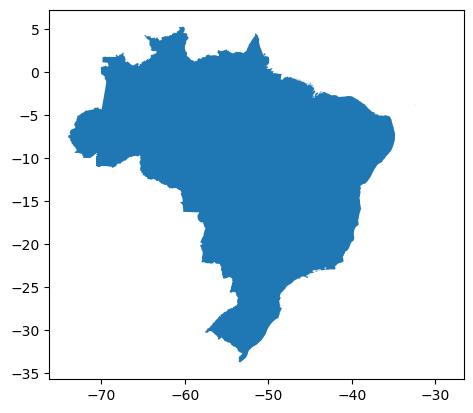

In [1]:
import pandas as pd
import geopandas as gpd

boundaries = gpd.read_file("/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/data/misc/gadm_410-BRA.geojson", engine="pyogrio")
boundaries.plot()

In [1]:
import cdsapi

c = cdsapi.Client()

c.retrieve(
    'satellite-cloud-properties',
    {
        'format': 'zip',
        'product_family': 'clara_a3',
        'origin': 'eumetsat',
        'variable': 'cloud_fraction',
        'climate_data_record_type': 'thematic_climate_data_record',
        'time_aggregation': 'monthly_mean',
        'year': [
            '1979', '1980', '1981',
            '1982', '1983', '1984',
            '1985', '1986', '1987',
            '1988', '1989', '1990',
            '1991', '1992', '1993',
            '1994', '1995', '1996',
            '1997', '1998', '1999',
            '2000', '2001', '2002',
            '2003', '2004', '2005',
            '2006', '2007', '2008',
            '2009', '2010', '2011',
            '2012', '2013', '2014',
            '2015', '2016', '2017',
            '2018', '2019', '2020',
        ],
        'month': [
            '01', '02', '03',
            '04', '05', '06',
            '07', '08', '09',
            '10', '11', '12',
        ],
    },
    '/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/data/cloud_cover/raw/download.zip')

2024-06-11 08:09:23,289 INFO Welcome to the CDS
2024-06-11 08:09:23,290 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/satellite-cloud-properties
2024-06-11 08:09:23,376 INFO Request is queued
2024-06-11 08:09:24,405 INFO Request is running
2024-06-11 08:15:41,817 INFO Request is completed
2024-06-11 08:15:41,818 INFO Downloading https://download-0001-clone.copernicus-climate.eu/cache-compute-0001/cache/data2/dataset-satellite-cloud-properties-de9875aa-073e-467f-9264-784d12e62862.zip to /pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/data/cloud_cover/raw/download.zip (2.5G)
2024-06-11 08:17:38,445 INFO Download rate 22M/s        


Result(content_length=2693649047,content_type=application/zip,location=https://download-0001-clone.copernicus-climate.eu/cache-compute-0001/cache/data2/dataset-satellite-cloud-properties-de9875aa-073e-467f-9264-784d12e62862.zip)

In [103]:
import xarray as xr
import rioxarray as rxr
import os
import numpy as np
import pandas as pd
import geopandas as gpd

In [34]:
boundaries = gpd.read_file("/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/data/misc/gadm_410-BRA.geojson", engine="pyogrio")

In [24]:
path = "/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/data/cloud_cover/raw/"
files = pd.Series(os.listdir(path))

In [25]:
cloud_cover = xr.open_mfdataset(path + files[files.str.contains(".nc")], chunks={"time": len(files[files.str.contains(".nc")])})

In [42]:
cloud_cover = cloud_cover.rio.write_crs("epsg:4326").rio.set_spatial_dims(x_dim="lon", y_dim="lat").rio.write_coordinate_system(inplace=True)

In [48]:
cloud_cover_subset = cloud_cover.cfc.rio.clip_box(*boundaries.total_bounds)

In [57]:
test = cloud_cover_subset.resample(time="1YE").mean().load()

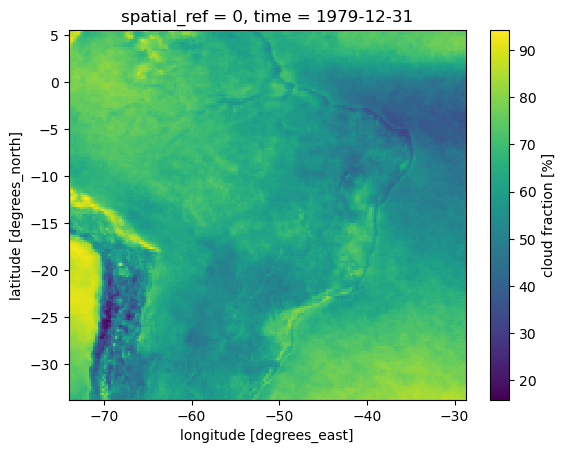

In [56]:
test.sel(time="1979-12-31").plot.imshow()

In [58]:
drainage_polygons = gpd.read_feather("/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/data/drainage/extracted_drainage_polygons.feather")

In [74]:
drainage_polygons_centroids = drainage_polygons[~drainage_polygons.is_empty].centroid

In [85]:
drainage_polygons_centroids

602   0       POINT (-62.53980 -12.67778)
      1       POINT (-62.50310 -12.68933)
      12      POINT (-62.50975 -12.67642)
      14      POINT (-62.60762 -12.67548)
      15      POINT (-62.60507 -12.66303)
                         ...             
1022  1517    POINT (-53.81703 -32.61223)
      1518    POINT (-53.83014 -32.61362)
      1519    POINT (-53.83855 -32.61651)
      1520    POINT (-53.82333 -32.62562)
      1521    POINT (-53.83930 -32.61739)
Length: 1171403, dtype: geometry

In [106]:
tmp = pd.DataFrame(
    {
        "cloud_cover": drainage_polygons_centroids.iloc[:100].apply(lambda x: test.sel(lon=x.x, lat=x.y, method="nearest").values),
        "year": [test.time.dt.year.values] * 100,
        }
    )

tmp.explode(["cloud_cover", "year"]).to_feather("/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/data/cloud_cover/extracted_cloud_cover.feather")

In [92]:
out = pd.DataFrame({tmp.values}, index=tmp.index)    

TypeError: unhashable type: 'numpy.ndarray'

In [80]:
test.sel(lon=drainage_polygons_centroids.iloc[:100].x.values, lat=drainage_polygons_centroids.iloc[:100].y.values, method="nearest")

<xarray.DataArray 'cfc' (time: 42, lat: 100, lon: 100)> Size: 3MB
array([[[68.        , 68.        , 68.        , ..., 69.66666667,
         69.66666667, 69.66666667],
        [68.        , 68.        , 68.        , ..., 69.66666667,
         69.66666667, 69.66666667],
        [68.        , 68.        , 68.        , ..., 69.66666667,
         69.66666667, 69.66666667],
        ...,
        [68.        , 68.        , 68.        , ..., 69.66666667,
         69.66666667, 69.66666667],
        [68.        , 68.        , 68.        , ..., 69.66666667,
         69.66666667, 69.66666667],
        [68.        , 68.        , 68.        , ..., 69.66666667,
         69.66666667, 69.66666667]],

       [[59.91666667, 59.91666667, 59.91666667, ..., 60.16666667,
         60.16666667, 60.16666667],
        [59.91666667, 59.91666667, 59.91666667, ..., 60.16666667,
         60.16666667, 60.16666667],
        [59.91666667, 59.91666667, 59.91666667, ..., 60.16666667,
         60.16666667, 60.16666667],
...
        [59.5       , 59.5       , 59.5       , ..., 59.75      ,
         59.75      , 59.75      ],
        [59.5       , 59.5       , 59.5       , ..., 59.75      ,
         59.75      , 59.75      ],
        [59.5       , 59.5       , 59.5       , ..., 59.75      ,
         59.75      , 59.75      ]],

       [[57.        , 57.        , 57.        , ..., 56.83333333,
         56.83333333, 56.83333333],
        [57.        , 57.        , 57.        , ..., 56.83333333,
         56.83333333, 56.83333333],
        [57.        , 57.        , 57.        , ..., 56.83333333,
         56.83333333, 56.83333333],
        ...,
        [57.        , 57.        , 57.        , ..., 56.83333333,
         56.83333333, 56.83333333],
        [57.        , 57.        , 57.        , ..., 56.83333333,
         56.83333333, 56.83333333],
        [57.        , 57.        , 57.        , ..., 56.83333333,
         56.83333333, 56.83333333]]])
Coordinates:
  * lat          (lat) float32 400B -12.62 -12.62 -12.62 ... -12.62 -12.62
  * lon          (lon) float32 400B -62.62 -62.62 -62.62 ... -62.38 -62.38
    spatial_ref  int64 8B 0
  * time         (time) datetime64[ns] 336B 1979-12-31 1980-12-31 ... 2020-12-31
Attributes:
    long_name:      cloud fraction
    standard_name:  cloud_area_fraction
    units:          %
    valid_min:      0
    valid_max:      100

In [60]:
drainage_polygons.centroid

602   0       POINT (-62.53980 -12.67778)
      1       POINT (-62.50310 -12.68933)
      2                              None
      3                              None
      4                              None
                         ...             
1022  1519    POINT (-53.83855 -32.61651)
      1520    POINT (-53.82333 -32.62562)
      1521    POINT (-53.83930 -32.61739)
      1522                           None
      1523                           None
Length: 2726217, dtype: geometry